In [2]:
import os

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import seaborn as sns
#import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [29]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

In [23]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Value'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [35]:
# SmoothedBRASIL, SmoothedGERMANY, SmoothedNETHERLANDS, SmoothedUSA
df = pd.read_csv(r'C:\Users\Michał\Desktop\iet\2_semestr\Eksploracja\SmoothedNETHERLANDS.csv', 
                 parse_dates = ['Date'], index_col = ['Date'])
df.head
#plt.xlabel('Date')
#plt.ylabel('Value')
#plt.plot(df)

<bound method NDFrame.head of             Unnamed: 0      Value
Date                             
2011-01-03           0  11.721316
2011-01-04           1  11.775897
2011-01-05           2  11.816541
2011-01-06           3  11.837227
2011-01-07           4  11.843094
...                ...        ...
2017-12-21        1785   9.918193
2017-12-22        1786   9.921135
2017-12-27        1787   9.925781
2017-12-28        1788   9.932506
2017-12-29        1789   9.939669

[1790 rows x 2 columns]>

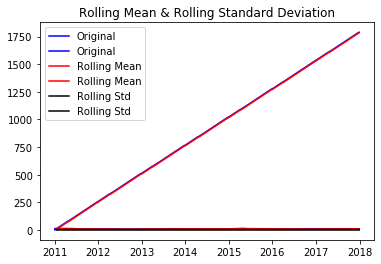

In [21]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [22]:
result = adfuller(df['Value'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.409575527081119
p-value: 0.13905200619977698
Critical Values:
	1%: -3.4340624951248593
	5%: -2.863179860030804
	10%: -2.5676430115666826


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


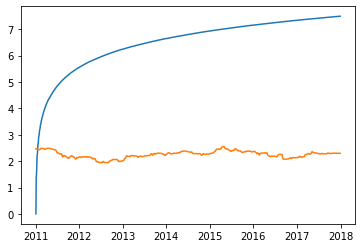

In [25]:
df_log = np.log(df)
plt.plot(df_log)

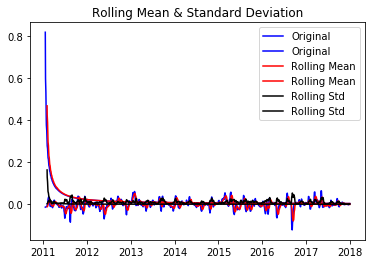

ADF Statistic: -6.2388918824641335
p-value: 4.75052087620969e-08
Critical Values:
	1%: -3.4340879605755426
	5%: -2.8631911014332876
	10%: -2.567648997323346


In [26]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

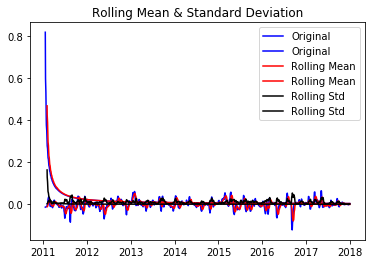

ADF Statistic: -6.2388918824641335
p-value: 4.75052087620969e-08
Critical Values:
	1%: -3.4340879605755426
	5%: -2.8631911014332876
	10%: -2.567648997323346


In [27]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

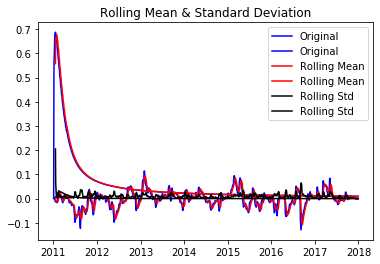

ADF Statistic: -4.92725216171749
p-value: 3.085586138767405e-05
Critical Values:
	1%: -3.434064603985686
	5%: -2.8631807909644835
	10%: -2.5676435072642447


In [28]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

In [47]:
df = pd.read_csv(r'C:\Users\Michał\Desktop\iet\2_semestr\Eksploracja\SmoothedNETHERLANDS.csv')

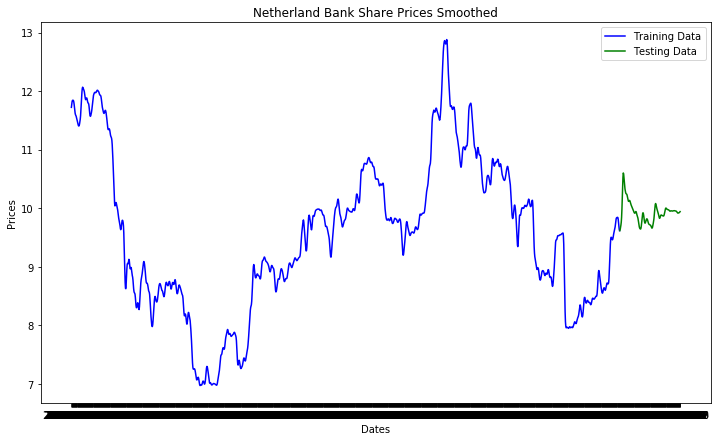

In [48]:
# dividing datasets into 0.7(train) and 0.3(test)

if ((0.9* len(df['Value'])) - int(0.7* len(df['Value']))) >= 0.5:
    x =int(0.9* len(df['Value'])) + 1
    y = int(0.1*len(df['Value']))
else:
    x =int(0.9* len(df['Value'])) 
    y = int(0.1*len(df['Value'])) + 1   


train_ar = df['Value'][:x].values
test_ar = df['Value'][x:].values
train_date = df['Date'][:x].values
test_date = df['Date'][x:].values

plt.figure(figsize=(12,7))
plt.title('Netherland Bank Share Prices Smoothed')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_date,train_ar, 'blue', label='Training Data')
plt.plot(test_date,test_ar, 'green', label='Testing Data')
plt.legend()
#plt.show()

In [50]:
history = [x for x in train_ar]

print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Testing Mean Squared Error: 0.000
Symmetric mean absolute percentage error: 1.924


In [51]:
historyP = [x for x in train_ar]

predictions1 = list()
for t in range(len(test_ar)):
    model = ARIMA(historyP, order=(5,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat[0])
    #obs = test_ar[t]
    historyP.append(yhat[0])

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\stats

Text(0.5, 1.0, 'title')

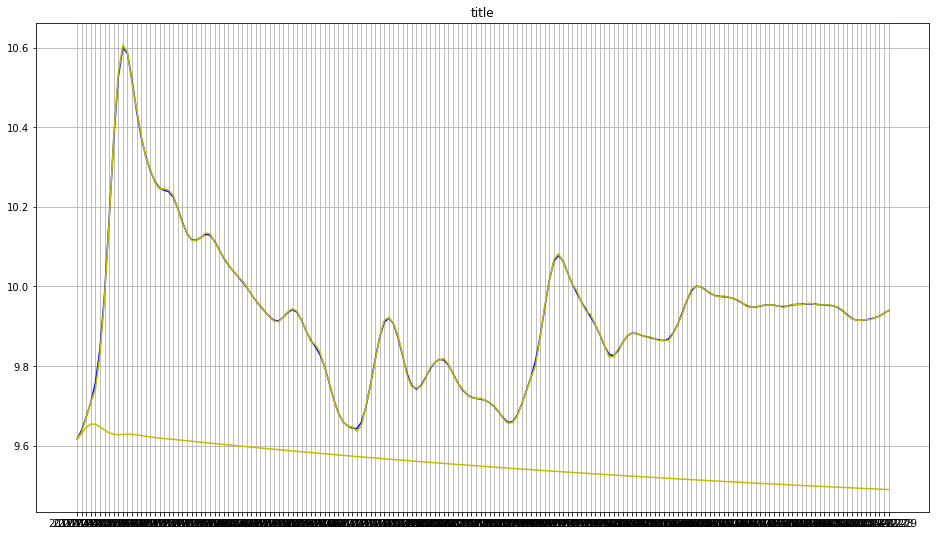

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))

plt.plot(test_date, test_ar, 'b')
plt.plot(test_date, predictions, 'y')
plt.plot(test_date, predictions1, 'y')
plt.grid('Netherlands')
plt.title('title')